# In this Notebook, my implementation of the recommending algorithm will be running
I am born in november, so the main focus will be on Data Analysis the second one on explainability and performance will be more or less irrelevant.



### In the first Cell we can find all necessary imports


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sn
print('imports done!')

imports done!


The Movielens Dataset, which is to be used, has been downloaded and added to the repository to get a maximised usability on every possible platform. Therefore, the only thing that has to be defined is the path to the data, so it can get loaded and be used for Data Analysis and recommending purposes.

In [34]:
movielens_dir = Path.cwd() / "ml-100k"

print(movielens_dir)

C:\Users\hp\Deep Learning LEcture\DeepLearningAbgabe\ml-100k


Additionally we will need the United States Zip Codes for our geographical analysis.
For this we need to download them at https://www.unitedstateszipcodes.org/zip-code-database/.
They have to be later put into the keras dataset folder, this path is printed in the cell above.
It is sufficient to use the Free version.

In [33]:
zip_code_cols = ['zip_code','type','decommissioned','primary_city','acceptable_cities','unacceptable_cities','state','county','timezone','area_codes','world_region','country','latitude','longitude','irs_estimated_population']
zip_code_dir = Path.cwd() / "zip_code_database.csv"
zip_codes_df = pd.read_csv(zip_code_dir, sep = ',', names= zip_code_cols, encoding='latin-1')
zip_codes_df.drop([0], inplace = True)
zip_codes_df.drop(['type','decommissioned','primary_city','acceptable_cities','unacceptable_cities','county','timezone','area_codes','world_region','country','latitude','longitude','irs_estimated_population'], axis = 1, inplace = True)
zip_codes_df['zip_code'] = zip_codes_df['zip_code'].astype('int64')

#print(zip_codes_df.head(20))
zip_codes_df.dtypes


zip_code     int64
state       object
dtype: object

The user data is read by using the pandas.read_csv function and loaded into a dataframe, the columns of each type of information is linked with their Keywords.

In [5]:
user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv(movielens_dir / "u.user", sep='|', names=user_cols,encoding='latin-1')

print('users done, onto ratings now')

users done, onto ratings now


Same as the user data, the ratings data is read and loaded into a dataframe, but because we have here the information of the timestamp, which we will not need in further Investigation, it can be dropped, so we wont use more space than needed.

In [6]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(movielens_dir / "u.data", sep='\t', names=ratings_cols)
#print(ratings.head())
ratings.drop(['timestamp'], axis=1, inplace=True)
#print(ratings.head())
print('ratings done, onto movies now')

ratings done, onto movies now


The movie data is also loaded into a dataframe and the attributes "IMDb_URL" and "video_release_date" get dropped. "IMDb_URL" because we have no need for this information and "video_release_date" because it is mostly not used.

The attribute "release_date" however has most times just the first of january as its date, so it can (and should for validity reasons) be stripped down to just the year. (See following lines 5 & 6)

To Save disc space, we also change the datatype for the genres, which are already meant as a Boolean, from int64 to boolean.

In [7]:
movie_cols = ['movie_id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance','Sci_Fi','Thriller','War','Western']
movies = pd.read_csv(movielens_dir / "u.item", sep='|', names=movie_cols, encoding='latin-1')
movies.drop(['IMDb_URL','video_release_date'], axis=1, inplace=True)
movies['release_date'] = pd.to_datetime(movies['release_date'])
movies['release_date'] = movies['release_date'].dt.year
movies.iloc[:, 3:] = movies.iloc[:, 3:].astype(bool)
#movies.sort_values(by='release_date', inplace=True)
#print(movies.head(10))
movie_ratings = pd.merge(movies, ratings)
df_all = pd.merge(movie_ratings, users)
print('all done and merged')
#print(df_all.dtypes)

all done and merged


## Data Analysis on Zip Codes:

To analyze whether the location of users is equally distributed in the United States, the user-dataframe is plotted onto the zip-codes-to-state-dataframe which distibution is then plotted as the following pie chart:
#piechart here

Problems by doing this were, that some users entered letters into the zip codes, so they had to be filtered out. Maybe these were zip codes from the UK, but they are in general more difficult to cope with than with only numerical ones.

Number of distinct Zipcodes: 795
925
Number of distinct States or Territories: 53
       state
IA        14
DC        14
AZ        14
TN        12
other    121


<AxesSubplot: ylabel='state'>

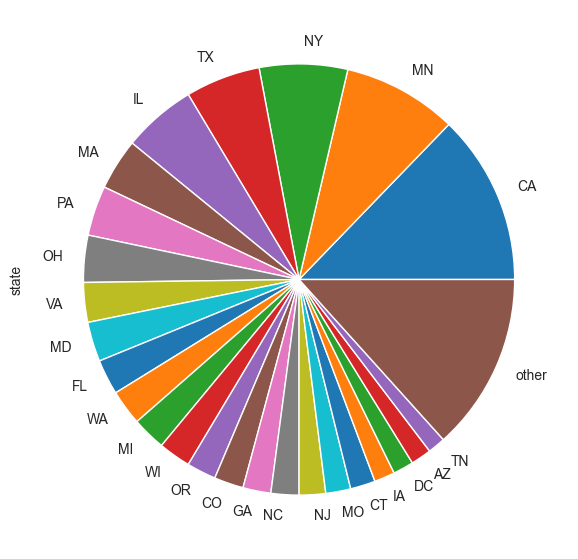

In [66]:
print('Number of distinct Zipcodes:', df_all.zip_code.nunique())

users['zip_code'] = pd.to_numeric(users['zip_code'], errors='coerce')
users.dropna(inplace = True)
users['zip_code'] = users['zip_code'].astype('int64')
users_zips_n_states = pd.merge(users, zip_codes_df, on= "zip_code")
print(len(users['zip_code']))
print('Number of distinct States or Territories:', users_zips_n_states.state.nunique())
users_states = users_zips_n_states['state'].value_counts().to_frame()

u_s_shrinked = users_states[:25].copy()
u_s_shrinked.loc['other'] = [users_states['state'][25:].sum()]
print(u_s_shrinked.tail())


user_state_flat = u_s_shrinked.transpose()
state_row = user_state_flat.iloc[0]
state_row.plot(kind='pie',figsize = (7,7), label = None)


Data Analysis on genres:

['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western']
       unknown  Action  Adventure  Animation  Children  Comedy  Crime  \
genre                                                                   
GENRE        2     251        135         42       122     505    109   

       Documentary  Drama  Fantasy  Film_Noir  Horror  Musical  Mystery  \
genre                                                                     
GENRE           50    725       22         24      92       56       61   

       Romance  Sci_Fi  Thriller  War  Western  
genre                                           
GENRE      247     101       251   71       27  


C:\Users\hp\AppData\Local\Temp\ipykernel_7992\3021690754.py:8: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  genre_df.set_axis(genre_cols, axis='columns', inplace = True)


<AxesSubplot: ylabel='GENRE'>

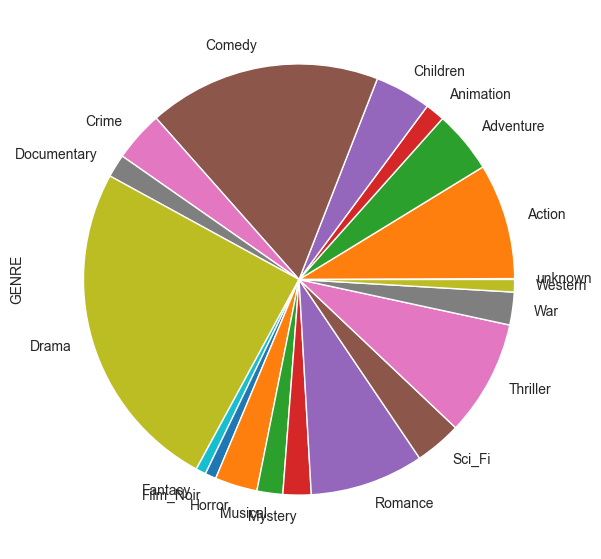

In [21]:
genre_cols = movie_cols[5:]
genre_series = [movies[genre] for genre in genre_cols]
print(genre_cols)
#print(genre_series)
genre_sums = [series.sum() for series in genre_series]
#print(genre_sums)
genre_df = pd.DataFrame(genre_sums).transpose()
genre_df.set_axis(genre_cols, axis='columns', inplace = True)
genre_df['genre'] = 'GENRE'
genre_df.set_index('genre', inplace= True)
print(genre_df)
row = genre_df.iloc[0]
row.plot(kind='pie', figsize = (7,7))

In [ ]:
df_all.sort_values(by='movie_id', inplace=True)
print(df_all.head())

In [ ]:
df_all.describe()

In [ ]:
# The 30 most rated movies
most_rated = df_all.groupby(by = 'movie_title').size().sort_values(ascending=False)[:30]
#lens.movie_title.value_counts()[:30]

movie_stats = df_all.groupby('movie_title').agg({'rating': [np.size, np.mean]}).sort_values([('rating', 'mean')], ascending=False)

rate_atleast_200 = movie_stats['rating']['size'] >= 200
movie_stats[rate_atleast_200].sort_values([('rating', 'mean')],ascending=False)

most_50 = df_all.groupby('movie_title').size().sort_values(ascending=False)[:50]

plt.figure()
sn.histplot(users['age'],bins = 30)
plt.title("Distribution of users' ages")
plt.ylabel('count of users')
plt.xlabel('age')

plt.hist(users['age'],bins=30)
plt.title("Distribution of users' ages")
plt.ylabel('count of users')
plt.xlabel('age')

labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
df_all['age_group'] = pd.cut(df_all.age, range(0, 81, 10), right=False, labels=labels)
df_all.groupby('age_group').agg({'rating': [np.size, np.mean]})
df_all.set_index('movie_title', inplace=True)

by_age = df_all.loc[most_50.index].groupby(['movie_title', 'age_group'])
by_age = by_age.rating.mean().unstack(1).fillna(0)

df_all.reset_index(inplace=True)
df_all.set_index('movie_title', inplace=True)

pivoted = df_all.pivot_table(index=['movie_title'],
                           columns=['gender'],
                           values='rating',
                           fill_value=0)

# First steps in deep learning

## Daten laden:
## Normieren:
## Modell erstellen: bzw Netz erstellen
Mit einem pretrained Model starten und darauf aufbauen und das neural network erweitern
### Flatten Layer:
nimmt Matrizen und erstellt daraus einen eindimensionalen Vektor mit den "Zeilen" hintereinander
### Dense Layer:
fully connected Layer, macht aus x Eingaben y Ausgabeparameter, ist zwar langsam aber dafür sehr präzise
### Output-Layer:
10 Möglichkeiten, je nach gewichtung wird ein Ausgang beim MNIST gewählt.
Für Movielens den Sigmoid ans Ende packen.
## Modell kompilieren:
Tensorflow-Ding
definiert optimizer (wie macht mans besser), Loss (Loss-Funktion) und Metrik (Was wird als gut bewertet)
## modell trainieren:
model.fit

## Modell predicten
kann man auch bezüglich der Fehler prüfen, z.B.: warum wurde das nicht erkannt?
model.predict(np.expand_dims(x_validation[10],0))
mit round drumherum geht es auf 1 bzw 0
## modell validieren:


anregungen vom 8.12.:

nicht bloaten,
data analysis; was genau haben wir da und auch nach split beachten, welche params wichtig sind und welche nicht
beachten und nichtbeachten von verteilungen und geografischen Angaben.

Gib mir deinen US-Staat und ich sag dir welchen Film du magst
oder gib mir einen Film und ich sag dir welchen Film du magst
oder